In [3]:
import numpy as np
import pandas as pd
from subprocess import check_output
import pandas as pd
import re
from nltk.corpus import stopwords
from sklearn import svm
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from tqdm import tqdm
import matplotlib.pyplot as plt


In [5]:
class Dataset:
    def __init__(self, path):
        self.path = path
        self.vectorizer = CountVectorizer(analyzer = "word",tokenizer = None,preprocessor = None,stop_words = None, max_features = 1000)
        self.stoi = {
            'ham': 0,
            'spam': 1
        }
        self.itos = {
            0: 'ham',
            1: 'spam'
        }
        
    def preprocess_data(self):
        email=pd.read_csv(self.path,encoding='latin-1')
        email=email.rename(columns = {'v1':'label','v2':'message'})
        cols=['label','message']
        email=email[cols]
        email=email.dropna(axis=0, how='any')
        clean_email=[]
        labels = []
        num_emails=email["message"].size
        for i in range(0,num_emails):
            clean_email.append(Dataset.email_processing(email["message"][i]))
            labels.append(self.stoi[email["label"][i]])
            
        email["Processed_Msg"]=clean_email
        cols2=["Processed_Msg","label"]
        email=email[cols2]
        
        self.X_train=email["Processed_Msg"][:5000]
        self.Y_train=labels[:5000]
        self.X_test=email["Processed_Msg"][5000:]
        self.Y_test=labels[5000:]
    
    @staticmethod
    def email_processing(raw_email):
        letters_only=re.sub("[^a-zA-Z]"," ",raw_email)
        words=letters_only.lower().split()
        stops=set(stopwords.words("english"))
        m_w=[w for w in words if not w in stops]
        return (" ".join(m_w))
    

    
    def classify_wise_data(self, image_data, labels):
        data = {}
        for i in range(len(np.unique(labels))):
            data[i] = []
        for i in range(image_data.shape[0]):
            data[labels[i]].append(image_data[i])
        for k in data.keys():
            data[k] = np.array(data[k])
        return data
    
    def load_data(self, data_type='train'):
        if data_type == 'train':
            data_features = self.vectorizer.fit_transform(self.X_train)
            labels = np.array(self.Y_train)
        else:
            data_features = self.vectorizer.transform(self.X_test)
            labels = np.array(self.Y_test)
        data_features=data_features.toarray()
        
        data = self.classify_wise_data(data_features, labels)
        return data_features, labels, data
dataset = Dataset(path = "spam.csv")
dataset.preprocess_data()
train_image_data, train_labels, train_data = dataset.load_data('train')
train_image_data.shape, train_labels.shape

((5000, 1000), (5000,))

In [6]:
train_data[0].shape, train_data[1].shape


((4327, 1000), (673, 1000))

In [7]:
val_image_data, val_labels, val_data = dataset.load_data('val')


In [8]:
val_image_data.shape, val_labels.shape


((572, 1000), (572,))

In [9]:
val_data[0].shape, val_data[1].shape


((498, 1000), (74, 1000))

In [17]:
class SVM:
    def __init__(self, total_class, C=1.0):
        self.C = C
        self.W = 0
        self.b = 0
        self.total_class = total_class
        
    def hinge_loss(self, W, b, X, Y):
        loss = 0.0
        loss += .5 * np.dot(W, W.T)
        m = X.shape[0]
        for i in range(m):
            ti = Y[i] * (np.dot(W,X[i].T) + b)
            loss += self.C * max(0,(1 - ti))
        return loss[0][0]
    
    def fit(self, X, Y, batch_size=50, learning_rate=0.001, max_iter=500):
        print(X.shape, Y.shape)
        num_features = X.shape[1]
        num_samples = X.shape[0]
        n = learning_rate
        c = self.C
        W = np.zeros((1, num_features))
        bias = 0
        losses = []  
        for i in tqdm(range(max_iter)):
            l = self.hinge_loss(W, bias, X, Y)
            losses.append(l)
            ids = np.arange(num_samples)
            np.random.shuffle(ids)
            for batch_start in range(0, num_samples, batch_size):
                gradw = 0
                gradb = 0
                for j in range(batch_start, batch_start + batch_size):
                    if j < num_samples:
                        i = ids[j]
                        ti =  Y[i] * (np.dot(W, X[i].T) + bias)
                        if ti > 1:
                            gradw += 0
                            gradb += 0
                        else:
                            gradw += c * Y[i] * X[i]
                            gradb += c * Y[i]  
                W = W - n * W + n * gradw
                bias = bias + n * gradb        
        self.W = W
        self.b = bias
        return W, bias, losses
    
    def get_data_pair(self, data1, data2):
        len1, len2 = data1.shape[0], data2.shape[0]
        samples = len1 + len2
        features = data1.shape[1]
        data_pair = np.zeros((samples,features))
        data_labels = np.zeros((samples,))
        data_pair[:len1,:] = data1
        data_pair[len1:,:] = data2
        data_labels[:len1] = -1
        data_labels[len1:] = +1
        return data_pair, data_labels
    
    def train(self, data, batch_size=50, learning_rate=0.00001, max_iter=500):
        self.svm_classifiers = {}
        for i in range(self.total_class):
            self.svm_classifiers[i] = {}
            for j in range(i + 1, self.total_class):
                xpair, ypair = self.get_data_pair(data[i], data[j])
                wts, b, loss = self.fit(xpair, ypair, batch_size = batch_size, learning_rate=learning_rate, max_iter=max_iter)
                self.svm_classifiers[i][j] = (wts, b)
                plt.plot(loss)
                plt.show()
        return loss
    
    def binary_predict(self, x, w, b):
        z  = np.dot(x, w.T) + b
        return 1 if z >= 0 else -1
        
    def predict(self, x):
        count = np.zeros((self.total_class,))
        for i in range(self.total_class):
            for j in range(i + 1, self.total_class):
                w, b = self.svm_classifiers[i][j]
                z = self.binary_predict(x, w, b)
                if z == 1:
                    count[j] += 1
                else:
                    count[i] += 1
        final_prediction = np.argmax(count)
        return final_prediction
    
    def accuracy(self, x, y):
#         x = self.pca.transform(x)
        count = 0
        predictions = []
        for i in range(x.shape[0]):
            prediction = self.predict(x[i])
            predictions.append(prediction)
            if(prediction == y[i]):
                count += 1
        return count / x.shape[0], predictions

  0%|          | 0/1000 [00:00<?, ?it/s]

(5000, 1000) (5000,)


100%|██████████| 1000/1000 [02:30<00:00,  6.63it/s]


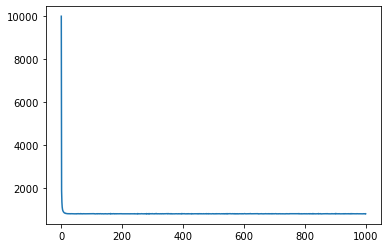

In [18]:
svm = SVM(len(train_data), 2)
loss = svm.train(train_data, batch_size=32, learning_rate=0.001, max_iter=1000)

In [21]:
import seaborn as sn
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(label_list,pred_list):
    cm_percentage=confusion_matrix(label_list,pred_list, normalize='true')
    cm_number=confusion_matrix(label_list,pred_list)
    print(cm_number)
    df_cm = pd.DataFrame(cm_percentage*100, range(2), range(2))
    plt.figure(figsize=(12,8))
    sn.set(font_scale=1.4) # for label size
    ax = sn.heatmap(df_cm, annot=True,cmap='coolwarm', annot_kws={"size": 16}, fmt='.2f')
    for t, number in zip(ax.texts, np.squeeze(cm_number.reshape(-1,1))): 
        t.set_text(t.get_text() + "% (" + str(number) + ")" )
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    
def evaluate(y_true, y_pred):
    return (
        accuracy_score(y_true, y_pred), 
        f1_score(y_true, y_pred, average='macro')
    )
def predict(model, data):
    predictions = []
    for image in tqdm(data):
        pred = model.predict(image)
        predictions.append(pred)
    return np.array(predictions)

In [22]:
train_predictions = predict(svm, train_image_data)
result = evaluate(train_labels, train_predictions)
print("Accuracy: {}, F1-score: {} of SVM on train dataset".format(result[0], result[1]))

100%|██████████| 5000/5000 [00:00<00:00, 46725.90it/s]

Accuracy: 0.9708, F1-score: 0.9312665336940869 of SVM on train dataset


In [23]:
predictions = predict(svm, val_image_data)
result = evaluate(val_labels, predictions)
print("Accuracy: {}, F1-score: {} of SVM".format(result[0], result[1]))

100%|██████████| 572/572 [00:00<00:00, 27615.39it/s]

Accuracy: 0.9755244755244755, F1-score: 0.9408305009605438 of SVM


[[498   0]
 [ 14  60]]


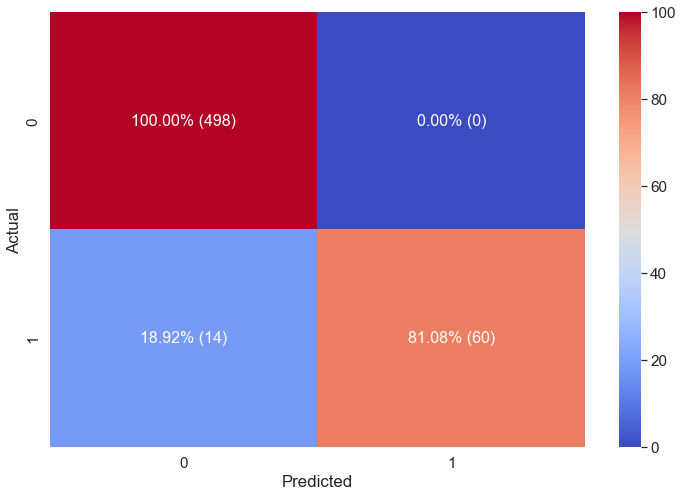

In [24]:
plot_confusion_matrix(val_labels, predictions)


In [25]:
#Import svm model
from sklearn import svm

#Create a svm Classifier
clf = svm.SVC(kernel='linear') # Linear Kernel

#Train the model using the training sets
clf.fit(train_image_data, train_labels)

SVC(kernel='linear')

In [26]:
y_pred = clf.predict(train_image_data)
result = evaluate(train_labels, y_pred)
print("Accuracy: {}, F1-score: {} of SVM on train dataset".format(result[0], result[1]))

Accuracy: 0.997, F1-score: 0.9935082420657084 of SVM on train dataset


In [27]:
#Predict the response for test dataset
y_pred = clf.predict(val_image_data)
result = evaluate(val_labels, y_pred)
print("Accuracy: {}, F1-score: {} of SVM on val dataset".format(result[0], result[1]))

Accuracy: 0.9842657342657343, F1-score: 0.9644610127368749 of SVM on val dataset


[[495   3]
 [  6  68]]


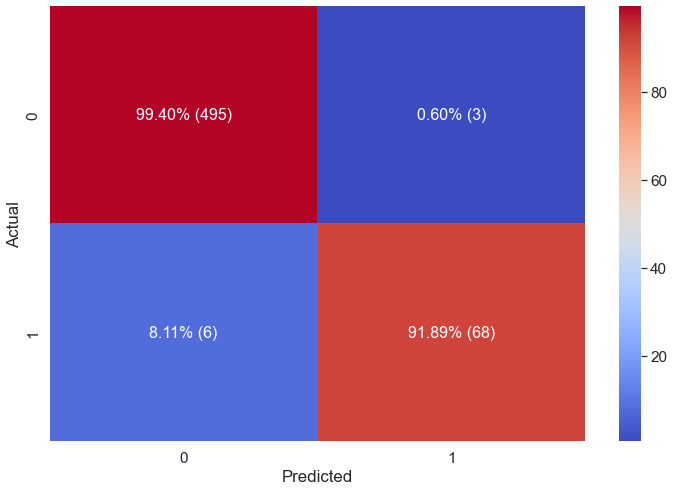

In [28]:
plot_confusion_matrix(val_labels, y_pred)


In [29]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors=5)
model.fit(train_image_data, train_labels)

KNeighborsClassifier()

In [30]:
y_pred = model.predict(train_image_data)
result = evaluate(train_labels, y_pred)
print("Accuracy: {}, F1-score: {} of SVM on train dataset".format(result[0], result[1]))

Accuracy: 0.95, F1-score: 0.8719102707878359 of SVM on train dataset


In [31]:
#Predict the response for test dataset
y_pred = model.predict(val_image_data)
result = evaluate(val_labels, y_pred)
print("Accuracy: {}, F1-score: {} of SVM on val dataset".format(result[0], result[1]))

Accuracy: 0.9458041958041958, F1-score: 0.8524288650870928 of SVM on val dataset


[[498   0]
 [ 31  43]]


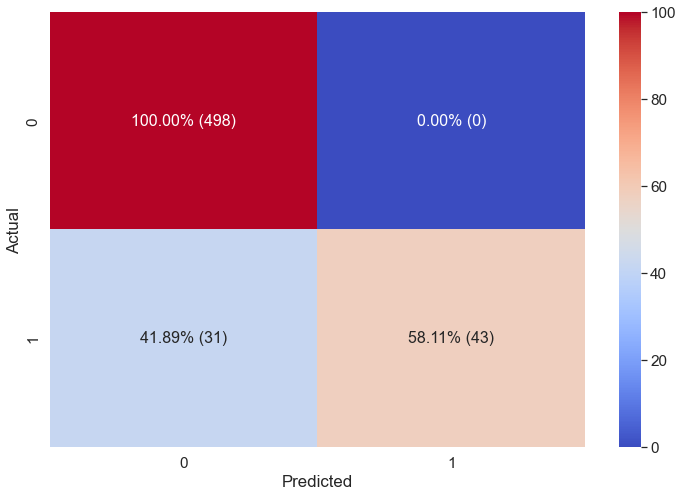

In [32]:
plot_confusion_matrix(val_labels, y_pred)
